In [21]:
# Dependencies
import json
import requests as req
import pandas as pd
import numpy as np
from xmljson import parker, Parker
from xml.etree.ElementTree import fromstring
import xml.etree.cElementTree as ET
from bs4 import BeautifulSoup
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import seaborn as sns

# Save config information
api_key = "X1-ZWz1g5wdt5pyq3_8nu8h"
url = "http://www.zillow.com/webservice/GetRegionChildren.htm?"
city = "Washington"
state = "DC"

# Build query URL
query_url = url + "zws-id=" + api_key + "&city=" + city +"&state=" + state + "&childtype=neighborhood" + "&output=json" 
print(query_url)

# Get Zillow data
zillow_response = req.get(query_url)

with open('zillow_response.xml', 'w') as f:
    f.write(zillow_response.text)
    
def parse_xml(xml):
    soup = BeautifulSoup(xml)
    return soup

if __name__ == '__main__':
    with open('zillow_response.xml', 'r') as zillow_xml:
        xml_contents = zillow_xml.read()
    #soup = parse_xml(xml_contents)
    #print(soup.prettify())
    temp_file = json.dumps(parker.data(fromstring(xml_contents)), indent=4)
    temp2_file = json.loads(temp_file)
    #print(json.dumps(parker.data(fromstring(xml_contents)), indent=4))

temp2_file

http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz1g5wdt5pyq3_8nu8h&city=Washington&state=DC&childtype=neighborhood&output=json


{'message': {'code': 0, 'text': 'Request successfully processed'},
 'request': {'childtype': 'neighborhood', 'city': 'Washington', 'state': 'DC'},
 'response': {'list': {'count': 135,
   'region': [{'id': 121697,
     'latitude': 38.928257,
     'longitude': -77.029264,
     'name': 'Columbia Heights',
     'url': 'http://www.zillow.com/local-info/DC-Washington/Columbia-Heights/r_121697/'},
    {'id': 121685,
     'latitude': 38.887156,
     'longitude': -76.998955,
     'name': 'Capitol Hill',
     'url': 'http://www.zillow.com/local-info/DC-Washington/Capitol-Hill/r_121685/'},
    {'id': 121774,
     'latitude': 38.946405,
     'longitude': -77.018236,
     'name': 'Petworth',
     'url': 'http://www.zillow.com/local-info/DC-Washington/Petworth/r_121774/',
     'zindex': 479300},
    {'id': 121668,
     'latitude': 38.92119,
     'longitude': -77.043406,
     'name': 'Adams Morgan',
     'url': 'http://www.zillow.com/local-info/DC-Washington/Adams-Morgan/r_121668/'},
    {'id': 12180

In [4]:
zillow_df = pd.DataFrame(temp2_file['response']['list']['region'])
zillow_df["Distance"] = ""
zillow_df.head()

,id,latitude,longitude,name,url,zindex,Distance
0,121697,38.928257,-77.029264,Columbia Heights,http://www.zillow.com/local-info/DC-Washington...,NaN,
1,121685,38.887156,-76.998955,Capitol Hill,http://www.zillow.com/local-info/DC-Washington...,NaN,
2,121774,38.946405,-77.018236,Petworth,http://www.zillow.com/local-info/DC-Washington...,479300.0,
3,121668,38.921190,-77.043406,Adams Morgan,http://www.zillow.com/local-info/DC-Washington...,NaN,
4,121806,38.830750,-76.990587,Washington Highlands,http://www.zillow.com/local-info/DC-Washington...,NaN,


In [5]:
stations = pd.read_csv('https://raw.githubusercontent.com/countryroads91/CapitalBikeShareZillowProject1/master/CapitalBikeShareDF.csv')
stations = stations[['start_station','start_date']]
stations['Latitude']=''
stations['Longitude']=''
stations['Neighborhood'] = ''
stations['start_station'] = stations.apply(lambda x: x.str.replace(' ','+'))
stations.head()

,start_station,start_date,Latitude,Longitude,Neighborhood
0,10th+&+e+st+nw,7/12/2012 13:04,,,
1,10th+&+florida+ave+nw,10/9/2013 8:55,,,
2,10th+&+g+st+nw,10/1/2016 8:41,,,
3,10th+&+k+st+nw,7/1/2015 6:32,,,
4,10th+&+monroe+st+ne,10/16/2010 13:55,,,


In [8]:
for index, row in stations.iterrows():
    url = 'https://geocoder.cit.api.here.com/6.2/geocode.json'
    app_id = 'YWmtXt51i4qEk4VlEacJ'
    app_code = 'Sna1EDDyBUc7m8EfvgmwMw'
    city = 'Washington'
    street = row['start_station']
    params = {'app_id':app_id,'app_code':app_code,'city':city,'street':street}
    
    response = req.get(url,params).json()
    try:
        lat = response['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']
        lng = response['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
    
        stations.set_value(index,'Latitude',lat)
        stations.set_value(index,'Longitude',lng)
    except IndexError:
        #print('Couldn\'t find coordinates for {0}'.format(street))
        pass
    
stations.head()

,start_station,start_date,Latitude,Longitude,Neighborhood
0,10th+&+e+st+nw,7/12/2012 13:04,38.6569,-87.1879,
1,10th+&+florida+ave+nw,10/9/2013 8:55,38.9205,-77.026,
2,10th+&+g+st+nw,10/1/2016 8:41,38.6569,-87.1879,
3,10th+&+k+st+nw,7/1/2015 6:32,38.6569,-87.1879,
4,10th+&+monroe+st+ne,10/16/2010 13:55,38.9324,-76.9959,


In [11]:
#This is to map the neighborhood to bike shares
#calculate the distance between the neighborhood lat/lon and the bikeshare lat/lon
#min distance between each bike share and all neighborhoods

#radius of the earth in km, needed for calculations
R = 6373.0

no_lat_lon = 0

#look through the lat/lon in the full list of unique bike locations: Assume the location 
for index,row in stations.iterrows():

    try:
        lat1 = radians(float(row["Latitude"]))
        lon1 = radians(float(row["Longitude"]))
    except ValueError:
        no_lat_lon += 1
        #print("Couldn't convert {}".format(str(row)))
        
    #setup a counter
    counter = 0
    
    #setup a list of distances
    distances = []
         
    #loop through all neigborhood locations
    for index,row2 in zillow_df.iterrows():
        
        neighborhood = row2["name"]
              
        #define the lat and lon of the neighborhood location in radians for use in calculations
        lat2 = radians(row2["latitude"])
        lon2 = radians(row2["longitude"])
                
        #calc distance between the bike share lat/lon and neighborhood lat/lon via series of equations found online
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        
        #add distance to the list of distances
        distances.append(distance)
        
        #change the selected neighborhood if the distance it represents (from the given bike share location)
        # is the shortest distance found yet
        if counter == 0:
            min_distance = distance
            selected_neighborhood = neighborhood
        elif distance < min_distance:
            min_distance = distance
            selected_neighborhood = neighborhood
            
        else:
            continue
    
        #bump up counter
        counter = counter + 1
        
    #add the neighborhood name to the corresponding row in the bike locations database
    
    row["Neighborhood"] = selected_neighborhood

#print("We couldn't find lat long for " + str(no_lat_lon) + " stations")

In [14]:
#stations.to_csv('stations_with_neighborhood.csv', index=False)
zillow_df = pd.read_csv('https://raw.githubusercontent.com/countryroads91/CapitalBikeShareZillowProject1/master/zillow_neighborhood_ZHVI.csv')
mdf = pd.merge(zillow_df, stations, how = 'right', left_on = 'RegionName', right_on = 'Neighborhood')
mdf.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2001-01,2001-02,2001-03,...,2017-06,2017-07,2017-08,2017-09,2017-10,start_station,start_date,Latitude,Longitude,Neighborhood
0,121697.0,Columbia Heights,Washington,DC,Washington,District of Columbia,243.0,148200.0,149700.0,151200.0,...,585700.0,585400.0,583700.0,582300.0,582500.0,11th+&+girard+st+nw,6/8/2017 4:32,38.926,-77.0249,Columbia Heights
1,121697.0,Columbia Heights,Washington,DC,Washington,District of Columbia,243.0,148200.0,149700.0,151200.0,...,585700.0,585400.0,583700.0,582300.0,582500.0,14th+&+girard+st+nw,5/5/2016 12:30,38.926,-77.0249,Columbia Heights
2,121697.0,Columbia Heights,Washington,DC,Washington,District of Columbia,243.0,148200.0,149700.0,151200.0,...,585700.0,585400.0,583700.0,582300.0,582500.0,14th+&+harvard+st+nw,9/20/2010 12:30,38.927,-77.0238,Columbia Heights
3,121697.0,Columbia Heights,Washington,DC,Washington,District of Columbia,243.0,148200.0,149700.0,151200.0,...,585700.0,585400.0,583700.0,582300.0,582500.0,14th+&+irving+st+nw,8/2/2016 13:21,38.9286,-77.032,Columbia Heights
4,121697.0,Columbia Heights,Washington,DC,Washington,District of Columbia,243.0,148200.0,149700.0,151200.0,...,585700.0,585400.0,583700.0,582300.0,582500.0,14th+st+&+spring+rd+nw,9/20/2010 19:14,38.9371,-77.0327,Columbia Heights


In [15]:
mdf = mdf.dropna(subset=['RegionName'])
mdf['start_date'] = pd.to_datetime(mdf.start_date)
mdf['start_month'] = mdf['start_date'].dt.strftime('%Y-%m')
mdf = mdf[(mdf['start_date'] < '2016-10-01 01:00:00')]

#get the prices of each neighborhood for each month before and after station installation (12 months either way)
price_times = []
prices = []

for m in range(1, 13):
    mdf[str(m) + 'm_before_start'] = (mdf['start_date'] + pd.DateOffset(months = -1*m)).dt.strftime('%Y-%m')
    mdf[str(m) + 'm_after_start'] = (mdf['start_date'] + pd.DateOffset(months = m)).dt.strftime('%Y-%m')
    price_times.append(str(m) + 'm_before_start')
    price_times.append(str(m) + 'm_after_start')
    prices.append(-1*m)
    prices.append(m)

price_map = dict(zip(price_times, prices))

for time, price in price_map.items():
    try:
        mdf[price] = mdf.lookup(mdf.index, mdf[time])
    except Exception:
        mdf[price] = 0
        pass

columns = prices
columns.extend(['RegionName', 'start_station', 'start_month'])
fdf = mdf[columns]

In [16]:
fdf

,-1,1,-2,2,-3,3,-4,4,-5,5,...,9,-10,10,-11,11,-12,12,RegionName,start_station,start_month
1,571400.0,579000.0,570200.0,581400.0,570400.0,584800.0,569100.0,587600.0,567600.0,589000.0,...,600000.0,559600.0,603300.0,555600.0,597600.0,548500.0,589700.0,Columbia Heights,14th+&+girard+st+nw,2016-05
2,406700.0,404800.0,408100.0,408800.0,411000.0,410500.0,411900.0,405600.0,408700.0,399800.0,...,394400.0,381800.0,396100.0,382700.0,398700.0,381300.0,400700.0,Columbia Heights,14th+&+harvard+st+nw,2010-09
3,581400.0,587600.0,579000.0,589000.0,575300.0,590700.0,571400.0,591600.0,570200.0,593900.0,...,589700.0,564600.0,585700.0,562200.0,585400.0,560900.0,583700.0,Columbia Heights,14th+&+irving+st+nw,2016-08
4,406700.0,404800.0,408100.0,408800.0,411000.0,410500.0,411900.0,405600.0,408700.0,399800.0,...,394400.0,381800.0,396100.0,382700.0,398700.0,381300.0,400700.0,Columbia Heights,14th+st+&+spring+rd+nw,2010-09
5,453800.0,463800.0,452500.0,469100.0,451200.0,472600.0,449200.0,476800.0,446800.0,481600.0,...,494800.0,428300.0,499500.0,424100.0,504100.0,419100.0,508400.0,Columbia Heights,15th+&+euclid+st++nw,2013-05
6,406700.0,404800.0,408100.0,408800.0,411000.0,410500.0,411900.0,405600.0,408700.0,399800.0,...,394400.0,381800.0,396100.0,382700.0,398700.0,381300.0,400700.0,Columbia Heights,16th+&+harvard+st+nw,2010-09
7,570400.0,571400.0,569100.0,575300.0,567600.0,579000.0,566500.0,581400.0,564600.0,584800.0,...,591600.0,548500.0,593900.0,541300.0,600000.0,535100.0,603300.0,Columbia Heights,16th+&+irving+st+nw,2016-03
8,406700.0,404800.0,408100.0,408800.0,411000.0,410500.0,411900.0,405600.0,408700.0,399800.0,...,394400.0,381800.0,396100.0,382700.0,398700.0,381300.0,400700.0,Columbia Heights,georgia+ave+and+fairmont+st+nw,2010-09
9,406700.0,404800.0,408100.0,408800.0,411000.0,410500.0,411900.0,405600.0,408700.0,399800.0,...,394400.0,381800.0,396100.0,382700.0,398700.0,381300.0,400700.0,Columbia Heights,park+rd+&+holmead+pl+nw,2010-09
10,538800.0,533400.0,541800.0,533700.0,541800.0,528900.0,541600.0,523400.0,542800.0,523800.0,...,526900.0,512600.0,528000.0,505000.0,529400.0,506300.0,530800.0,Capitol Hill,13th+&+d+st+ne,2010-10


In [19]:
#read in csv data
data_df = fdf
#preview data
data_df

#setup neighborhood averages using groupby
nb_data = data_df.groupby('RegionName')

#create data frame of average home prices
nb_ave = nb_data.mean()

nb_ave.reset_index(inplace = True)

#check the column header
print(nb_ave.columns)

#create a dataframe of bike station counts
nb_stations = nb_data.count()

nb_stations.head()

Index(['RegionName',           -1,            1,           -2,            2,
                 -3,            3,           -4,            4,           -5,
                  5,           -6,            6,           -7,            7,
                 -8,            8,           -9,            9,          -10,
                 10,          -11,           11,          -12,           12],
      dtype='object')


,-1,1,-2,2,-3,3,-4,4,-5,5,...,-9,9,-10,10,-11,11,-12,12,start_station,start_month
RegionName,,,,,,,,,,,,,,,,,,,,,
Adams Morgan,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Anacostia,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Barney Circle,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Benning,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Berkley,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


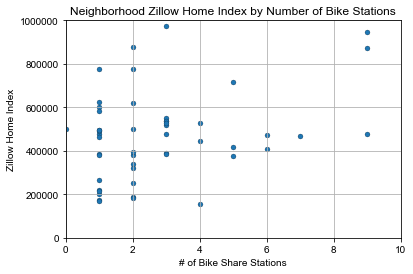

In [23]:
#create a graph that shows number of bikeshares and price 12 mo

plt.scatter(nb_stations[-1],
            nb_ave[12],
            #labels = nb_ave["RegionName"], 
            s = 25,
            edgecolor="black", 
            linewidths=.2,
            marker="o")

plt.title("Neighborhood Zillow Home Index by Number of Bike Stations")
plt.ylabel("Zillow Home Index")
plt.xlabel("# of Bike Share Stations")
plt.xlim((0,10))
plt.ylim(0,1000000)
plt.grid(True)
sns.set(style = "darkgrid")

plt.savefig("avg_value_by_stations.png")
plt.show()

In [24]:
#transpose the original data to make plotting easier
transposed_df = nb_ave.transpose()

#reset index to pull month counts into table
transposed_df.reset_index(inplace = True)

#create a series of neighborhood names
nb_names = transposed_df.iloc[0,:] 

#replace column headers with neighborhood names
for x in range(55):
    
    transposed_df.columns.values[x+1] = nb_names[x]
    
transposed_df.columns.values[0] = "Months Before/After Install"

#drop the row with neighborhood names
transposed_df = transposed_df.drop([0])

transposed_df.reset_index(inplace = True)

transposed_df["Months Before/After Install"] = transposed_df["Months Before/After Install"].astype(float)

#print(transposed_df.columns.values)
transposed_df


,level_0,Months Before/After Install,Adams Morgan,Anacostia,Barney Circle,Benning,Berkley,Bloomingdale,Brightwood Park,Brookland,...,Sixteenth Street Heights,Southwest Waterfront,Stronghold,Takoma,Trinidad,Truxton Circle,U Street Corridor,Wakefield,Wesley Heights,Woodley Park
0,1,-1.0,460517,194000,450500,167700,1.5705e+06,438800,350633,408475,...,489100,327500,435500,444789,289400,400300,506400,441750,502800,621000
1,2,1.0,463817,192500,452800,165400,1.608e+06,443200,354333,417700,...,494033,325800,448700,451295,300250,398300,515767,445200,501700,625200
2,3,-2.0,460433,194000,450000,168500,1.5556e+06,440300,348033,404900,...,488033,326150,428200,441211,285150,399500,500100,439950,498200,623100
3,4,2.0,465350,193250,453600,163200,1.6183e+06,447700,358033,420175,...,497300,326900,454800,453679,305550,397600,518300,448050,501900,630000
4,5,-3.0,460633,193400,449100,170700,1.5443e+06,439500,344600,401600,...,488667,323150,NaN,437505,283550,399600,495633,440700,495400,619500
5,6,3.0,466133,193700,456000,161700,1.6145e+06,450800,361867,420875,...,498600,326650,461200,455874,310150,396200,520233,454600,503000,627300
6,7,-4.0,460400,193100,447100,172600,1.5428e+06,436700,341333,397675,...,489200,320850,NaN,433268,282400,395500,492200,442700,488300,613600
7,8,4.0,466317,193000,458400,161400,1.6054e+06,455200,364567,422075,...,498267,326400,462900,458353,314350,390300,522433,464250,504200,624100
8,9,-5.0,459317,193200,445800,174200,1.5535e+06,434200,338567,405700,...,486633,318750,NaN,428505,300500,386200,488167,444600,473900,609800
9,10,5.0,466550,191850,459900,161600,1.5968e+06,462600,367500,425100,...,501233,328400,460100,461326,318050,383700,525000,471850,501500,623800


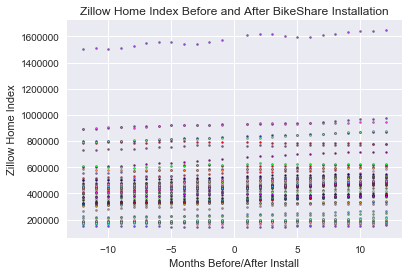

In [25]:
#create a graph of zillow home index by # of bike share stations
plt.clf()

colors = []
for color in range(55):
    colors.append

for column in range(55):

    plt.scatter(transposed_df["Months Before/After Install"],
                transposed_df[nb_names[column]],
                label = transposed_df.columns[column],
                c = np.random.rand(3,),
                s= 4,
                edgecolor="black", 
                linewidths=.2,
                marker="o")

    plt.title("Zillow Home Index Before and After BikeShare Installation")
    plt.ylabel("Zillow Home Index")
    plt.xlabel("Months Before/After Install")
    plt.grid(True)
    sns.set(style = "darkgrid")

plt.savefig("monthly_prices.png")
plt.show()

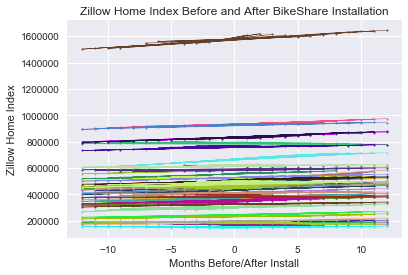

In [26]:
#create a graph of zillow home index by # of bike share stations
plt.clf()

# Set x axis and variables
x_axis = np.arange(-12, 12, 1)

for column in range(55):
    
    months = transposed_df["Months Before/After Install"]
    ZHI = transposed_df[nb_names[column]]
    
    # Each point on the sine chart is marked by a blue circle
    handle, = plt.plot(months, ZHI, marker ='o', color= np.random.rand(3,), label= nb_names[column], alpha = 1, linewidth = 0.5, ms = 2)
    


    plt.title("Zillow Home Index Before and After BikeShare Installation")
    plt.ylabel("Zillow Home Index")
    plt.xlabel("Months Before/After Install")
    plt.grid(True)
    sns.set(style = "darkgrid")

plt.show()

In [28]:
#Average before and after a year each station's start date
avg_before = data_df.groupby(['RegionName']).mean()[-12]
avg_after = data_df.groupby(['RegionName']).mean()[12]
by_region = data_df['RegionName'].value_counts()
b4_after_df=pd.DataFrame({'NumberOfStation': by_region,
                         'Average Price 1 Year Before': avg_before,
                         'Average Price 1 Yr After': avg_after})
b4_after_df.index.name = 'RegionName'
b4_after_df.reset_index()
b4_after_df.head()

,Average Price 1 Year Before,Average Price 1 Yr After,NumberOfStation
RegionName,,,
Adams Morgan,4.473333e+05,4.736333e+05,6
Anacostia,1.925000e+05,1.895000e+05,2
Barney Circle,4.483000e+05,4.794000e+05,1
Benning,1.853000e+05,1.735000e+05,1
Berkley,1.501600e+06,1.644900e+06,1


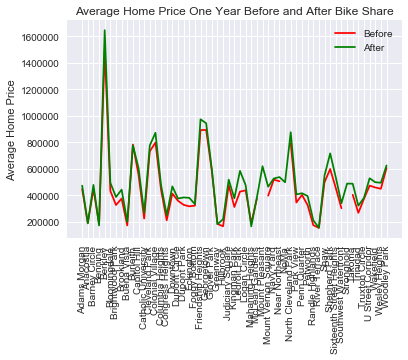

In [29]:
# Plot average price 1 year before and after
before, = plt.plot(b4_after_df.index, b4_after_df['Average Price 1 Year Before'], color="red", label="Before" )

# Plot the unemployment values for a single country
after, = plt.plot(b4_after_df.index, b4_after_df['Average Price 1 Yr After'], color="green", label="After" )

# Create a legend for our chart
plt.legend(handles=[before, after], loc="best")
plt.xticks(rotation=90)
plt.ylabel("Average Home Price")
plt.xlabel("")
plt.title("Average Home Price One Year Before and After Bike Share")
plt.savefig("BeforeAfterBikeShare.png")
# Show the chart
plt.show()

In [30]:
station_zillow = fdf
stations = station_zillow['RegionName'].value_counts()
stations.index

Index(['Takoma', 'Capitol Hill', 'Dupont Circle', 'Foggy Bottom',
       'Columbia Heights', 'Georgetown', 'Colonial Village', 'Downtown',
       'Navy Yard', 'Adams Morgan', 'Park View', 'Shepherd Park',
       'Kingman Park', 'Penn Quarter', 'River Terrace', 'Brookland',
       'Friendship Heights', 'Brightwood Park', 'U Street Corridor',
       'Logan Circle', 'Stronghold', 'Near Northeast', 'Judiciary Square',
       'Shaw', 'Dupont Park', 'Sixteenth Street Heights', 'Wakefield',
       'Congress Heights', 'Eckington', 'Mount Pleasant', 'Greenway',
       'Petworth', 'Cleveland Park', 'Southwest Waterfront',
       'North Cleveland Park', 'Trinidad', 'Anacostia', 'Truxton Circle',
       'Catholic University', 'Ledroit Park', 'Hillbrook',
       'Mount Vernon Square', 'Mahaning Heights', 'Wesley Heights', 'Berkley',
       'NoMa', 'Bloomingdale', 'Randle Highlands', 'Benning', 'Buena Vista',
       'Barney Circle', 'Burleith', 'McLean Gardens', 'Glover Park',
       'Woodley Park']

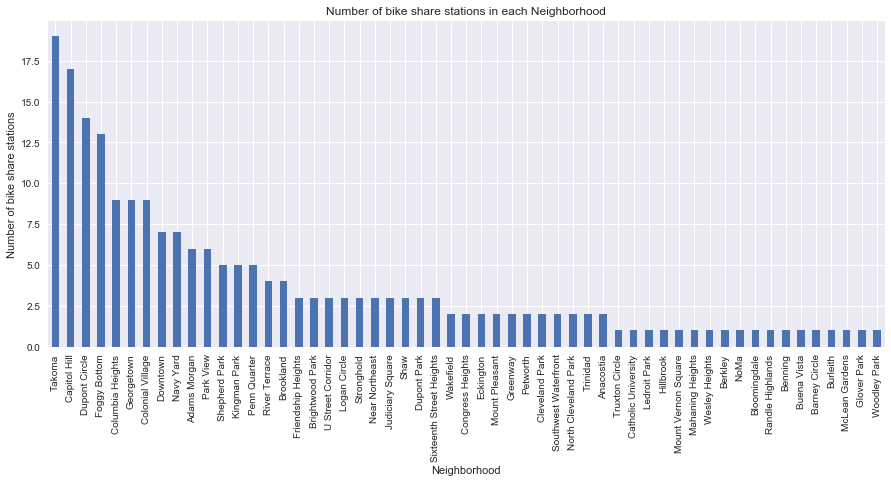

In [31]:
#bar chart that shows the number of bike stations for each neighborhood
stations.plot.bar(figsize=(15,6))
plt.title('Number of bike share stations in each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of bike share stations')
plt.show()

In [33]:
#lists with average price change for each neighborhood over each 3, 6 and 12 month period
three = []
six = []
twelve = []
three1 = []
six1 = []
twelve1 = []
for index, row in station_zillow.iterrows():
    change3 = ((row[3]-row[0])/row[0])*100
    #if (np.isnan(change3) != True):
    three.append(change3)
    change6 = ((row[6]-row[0])/row[0])*100
    #if (np.isnan(change6) != True):
    six.append(change6)
    change12 = ((row[12]-row[0])/row[0])*100
    #if (np.isnan(change12) != True):
    twelve.append(change12)
        
    change3a = ((row[0]-row[-3])/row[-3])*100
    #if (np.isnan(change3a) != True):
    three1.append(change3a)
    change6a = ((row[0]-row[-6])/row[-6])*100
    #if (np.isnan(change6a) != True):
    six1.append(change6a)
    change12a = ((row[0]-row[-12])/row[-12])*100
    #if (np.isnan(change12a) != True):
    twelve1.append(change12a)

In [34]:
months_change_px = pd.DataFrame()
months_change_px['Neighborhood']=station_zillow['RegionName']
months_change_px['3 months before'] = three
months_change_px['6 months before'] = six
months_change_px['12 months before'] = twelve
months_change_px['3 months after'] = three1
months_change_px['6 months after'] = six1
months_change_px['12 months after'] = twelve1
months_change_px.head()

,Neighborhood,3 months before,6 months before,12 months before,3 months after,6 months after,12 months after
1,Columbia Heights,2.345117,3.377669,3.202660,0.175316,0.864960,4.175023
2,Columbia Heights,0.934350,-1.745759,-1.475289,-1.046229,0.419753,6.661421
3,Columbia Heights,1.599587,3.199174,0.395597,1.060316,1.928471,3.654840
4,Columbia Heights,0.934350,-1.745759,-1.475289,-1.046229,0.419753,6.661421
5,Columbia Heights,4.142794,7.227854,12.031732,0.576241,2.184193,8.279647
